
KeplerLightCurve.ipynb
==

---------------------------------

‹ KeplerLightCurve.ipynb › Copyright (C) ‹ 2017 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk ›
This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---------------------------------

[AMS - 170829] Notebook created for **TIARA Astrostatistics Summer School, Taipei, September 2017**<br>
[AMS - 180528] Notebook updated for **JEDI Madagascar Workshop, Nosy Be, May 2018**

This notebook runs through the Gaussian Process Modelling described in **Example 3** of https://arxiv.org/pdf/1703.09710.pdf and builds on the methodology presented in the accompanying lecture: "Can You Predict the Future..?"

It uses a number of Python libraries, which are all installable using **pip**.

This example uses the **v0.2.1** george GPM library (http://dan.iel.fm/george/). To install the george v0.2.1 (rather than 0.3.0) use:

> pip install george==0.2.1

---------------------------------

In [1]:
%matplotlib inline

Import some libraries:

In [2]:
import numpy as np
import pylab as pl

Import the george Gaussian Process Modelling library and the george covariance kernels:

In [3]:
import george
from george import kernels

Specify the datafile containing Kepler data for the object KIC 1430163:

In [5]:
filename="KIC1430163.tbl"
datafile = open(filename,'r')

Read the Kepler data from the file:

In [6]:
time=[];value=[]
while True:
    line = datafile.readline()
    if not line: break
        
    items=line.split()
    if (items[0][0]!='|'):
        time.append(float(items[1]))
        value.append(float(items[2]))
        
time=np.array(time)
value=np.array(value)

The paper says:

*We set the mean function to zero*
   
and we can see from Fig 7 that the data have also been normalised to have a maximum value of one.

So, let's also do that:

In [7]:
mean = np.mean(value)
value-=mean

norm = np.max(value)
value/=norm

And the time has been made relative to the first measurement:

In [8]:
day1 = time[0]
time-=day1

Make a plot like the one in Figure 7:

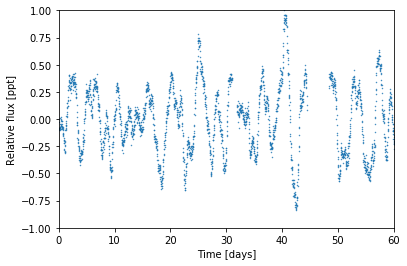

In [9]:
pl.subplot(111)
pl.scatter(time,value,s=0.2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

In the paper there are two suggested kernels for modelling the covariance of the Kepler data (Eqs. 55 & 56). In the paper the authors fit Eq 56 - here we are going to fit **Eq. 55**.

We can do this using a combination of kernels from the george library. 

Exponential Squared Kernel:
$$
k_1(x_i,x_j)=h_1 \exp(−\frac{(x_i-x_j)^2}{2 \sigma^2})
$$

Exp-Sine-Squared Kernel:
$$
k_2(x_i,x_j)=h_2 \exp \left( \Gamma \sin^2 \left[ \frac{\pi}{P}|x_i - x_j|\right] \right)
$$

Our combined kernel is therefore:

$$
k(x_i,x_j)=h \exp(−\frac{(x_i-x_j)^2}{2 \sigma^2})\exp \left( \Gamma \sin^2 \left[ \frac{\pi}{P}|x_i - x_j|\right] \right)
$$

where $h = h_1 h_2$.

However, following https://arxiv.org/pdf/1706.05459.pdf, we are also going to add a white noise kernel in:

$$
k_3(x_i,x_j)=c \delta_{ij}
$$

So our final kernel will be:

$$
k = (k_1k_2) + k_3
$$

In [10]:
# h =1.0; sigma = 1.0; Gamma = 2.0/1.0^2; P = 3.8
k1 = 1.0**2 * kernels.ExpSquaredKernel(1.0**2) \
                        * kernels.ExpSine2Kernel(2.0 / 1.0**2, 3.8)
    
k2 = kernels.WhiteKernel(0.01)

kernel = k1+k2

In [11]:
# first we feed our combined kernel to the George library:
gp = george.GP(kernel, mean=0.0)

# then we compute the covariance matrix:
gp.compute(time)

In [12]:
t = np.arange(np.min(time),np.max(time),0.1)

# calculate expectation and variance at each point:
mu, cov = gp.predict(value, t)
std = np.sqrt(np.diag(cov))

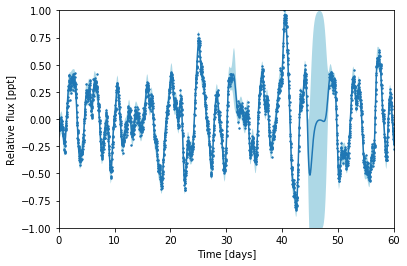

In [13]:
ax = pl.subplot(111)
pl.plot(t,mu)
ax.fill_between(t,mu-std,mu+std,facecolor='lightblue', lw=0, interpolate=True)
pl.scatter(time,value,s=2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

The paper says:

*As with the earlier examples, we start by estimating the MAP parameters using L-BFGS-B*

So let's do that. We'll use the scipy optimiser, which requires us to define a log(likelihood) function and a function for the gradient of the log(likelihood):

In [14]:
def nll(p):
    
    # Update the kernel parameters:
    gp.kernel[:] = p
    
    #  Compute the loglikelihood:
    ll = gp.lnlikelihood(value, quiet=True)
    
    # The scipy optimizer doesn’t play well with infinities:
    return -ll if np.isfinite(ll) else 1e25

In [15]:
def grad_nll(p):
    # Update the kernel parameters: 
    gp.kernel[:] = p
    
    #  Compute the gradient of the loglikelihood:
    gll = gp.grad_lnlikelihood(value, quiet=True)
    
    return -gll

I'm going to set bounds on the available parameters space, i.e. our prior volume, using the ranges taken from Table 4 of https://arxiv.org/pdf/1706.05459.pdf

In [16]:
import scipy.optimize as op

# extract our initial guess at parameters
# from the george kernel and put it in a 
# vector:
p0 = gp.kernel.vector

# set prior ranges
# Note that these are in *logarithmic* space
bnds = ((-20.,0.),(2.,8.),(0.,3.),(np.log(0.5),np.log(100.)),(-20.,0))

# run optimization:
results = op.minimize(nll, p0, method='L-BFGS-B', jac=grad_nll, bounds=bnds)

In [17]:
# print the value of the optimised parameters:
print np.exp(results.x)

[6.80157205e-02 7.38905610e+00 1.05904701e+01 3.89480675e+00
 1.33416117e-03]


The key parameter here is the period, which is the fourth number along. We expect this to be about 3.9 and... it is already coming out with that kind of value!

From the paper:

*This star has a published rotation period of 3.88 ± 0.58 days, measured using traditional periodogram and autocorrelation function approaches applied to Kepler data from Quarters 0–16 (Mathur et al. 2014), covering about four years.*

Let's now pass these optimised parameters to george and recompute our prediction:

In [18]:
# pass the parameters to the george kernel:
gp.kernel[:] = results.x

In [19]:
t = np.arange(np.min(time),np.max(time),0.1)

# calculate expectation and variance at each point:
mu, cov = gp.predict(value, t)
std = np.sqrt(np.diag(cov))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


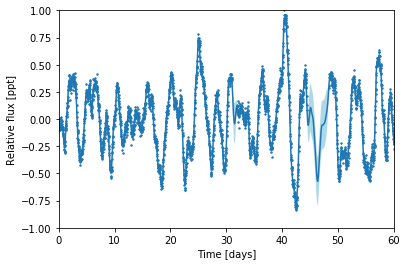

In [20]:
ax = pl.subplot(111)
pl.plot(t,mu)
ax.fill_between(t,mu-std,mu+std,facecolor='lightblue', lw=0, interpolate=True)
pl.scatter(time,value,s=2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

---------------------------------------------------